In [1]:
import torch
import matplotlib.pyplot as plt
from context import *

## Learn from Data

In [2]:
mdl = RGGenerator([1], 1, hdims=[16, 8], hyper_dim=16)
opt = torch.optim.Adam(mdl.parameters(), lr=0.01)

In [3]:
x_dat = torch.tensor([-1.]*50+[1.]*50)
x_dat = x_dat + 0.1*torch.randn_like(x_dat)
x_dat = x_dat[:,None,None]
x_dat.shape

torch.Size([100, 1, 1])

In [19]:
mdl.train()
opt.param_groups[0]['lr'] = 0.001
for _ in range(10):
    opt.zero_grad()
    out = mdl.nll_loss(x_dat, lk=0.01, lg=0.01, atol=1e-3, rtol=1e-3)
    loss = out[0]
    loss.backward()
    opt.step()
    print(*[f'{o.item():5.2f}' for o in out])

-0.75 -0.80  0.28  4.63
 0.32  0.29  0.30  2.62
-0.09 -0.13  0.31  3.56
 0.38  0.35  0.30  2.43
 0.21  0.18  0.32  2.71
 0.51  0.49  0.38  1.59
 0.44  0.41  0.46  2.00
 0.27  0.24  0.50  2.70
 0.27  0.24  0.48  2.38
 0.21  0.19  0.41  2.33


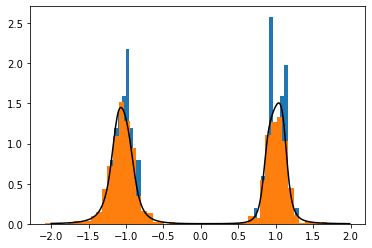

In [20]:
mdl.eval()
x_smp = mdl.sample(1000)
plt.hist(x_dat.squeeze().tolist(), bins=50, density=True);
plt.hist(x_smp.squeeze().tolist(), bins=50, density=True);
xs = torch.arange(-2,2,0.01)
with torch.no_grad():
    ps = mdl.log_prob(xs.view(-1,1,1), div='exact').exp()
plt.plot(xs, ps, 'k-');

## Learn from Energy

In [21]:
mdl = RGGenerator([1], 1, hdims=[16, 8], hyper_dim=16)
opt = torch.optim.Adam(mdl.parameters(), lr=0.01)

In [22]:
def energy(x):
    return torch.squeeze((x-1)**2/(2*(1/3)**2))

In [28]:
mdl.train()
opt.param_groups[0]['lr'] = 0.001
for _ in range(10):
    opt.zero_grad()
    out = mdl.free_loss(energy, 1000, lk=0.01, lg=0.01, atol=1e-3, rtol=1e-3)
    loss = out[0]
    loss.backward()
    opt.step()
    print(*[f'{o.item():5.2f}' for o in out])

 1.90  1.86  1.78  2.41
 1.70  1.67  1.65  1.95
 1.67  1.64  1.75  1.61
 1.62  1.58  1.69  1.45
 1.75  1.72  1.76  1.37
 1.73  1.70  1.63  1.21
 1.69  1.66  1.58  1.21
 1.71  1.68  1.45  1.24
 1.65  1.63  1.39  1.16
 1.57  1.55  1.39  1.09


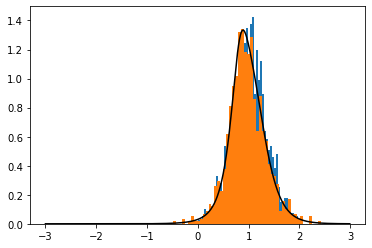

In [29]:
mdl.eval()
x_smp = mdl.sample(1000)
x_dat = torch.randn_like(x_smp)/3+1
plt.hist(x_dat.squeeze().tolist(), bins=50, density=True);
plt.hist(x_smp.squeeze().tolist(), bins=50, density=True);
xs = torch.arange(-3,3,0.01)
with torch.no_grad():
    ps = mdl.log_prob(xs.view(-1,1,1), div='exact').exp()
plt.plot(xs, ps, 'k-');